<a href="https://colab.research.google.com/github/Euler912/Breast-Cancer-Classification/blob/main/Machine_Learning_Classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**bold text**#packs

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
bc=datasets.load_breast_cancer()
import time
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold



#Preparing the datasets

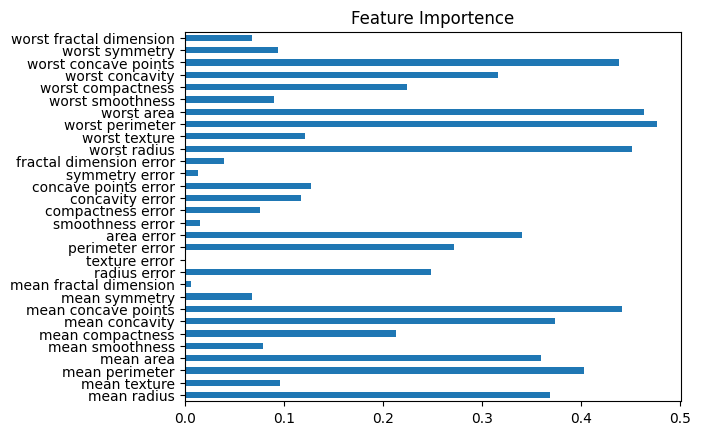

In [ ]:
X,y= bc.data ,bc.target
df = pd.DataFrame(data=bc.data, columns=bc.feature_names)
df2 = df.assign(target=bc.target)
X=df2.iloc[0:569,0:30]
Y=df2['target']
importances = mutual_info_classif(X, Y)
feat_importances=pd.Series(importances,df2.columns[0:len(df2.columns)-1])
feat_importances.plot(kind='barh')
plt.title("Feature Importence")
plt.show()
bc=df.drop(["worst fractal dimension", "worst symmetry","fractal dimension error","symmetry error","smoothness error","mean texture"], axis=1)
#print(bc.head(6))
X=bc.to_numpy()
y=Y.to_numpy()


In [ ]:
n_sample,n_features=X.shape
sc=StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)
X_val=sc.fit_transform(X_val)

X_val=torch.from_numpy(X_val.astype(np.float32))
X_train=torch.from_numpy(X_train.astype(np.float32))
X_test=torch.from_numpy(X_test.astype(np.float32))
y_train=torch.from_numpy(y_train.astype(np.float32))
y_test=torch.from_numpy(y_test.astype(np.float32))
y_val=torch.from_numpy(y_val.astype(np.float32))

y_train=y_train.view(y_train.shape[0],1)
y_test=y_test.view(y_test.shape[0],1)
y_val=y_val.view(y_val.shape[0],1)


In [ ]:
print(X_val.shape)
print(X_train.shape)
print(X_test.shape)

torch.Size([114, 24])
torch.Size([341, 24])
torch.Size([114, 24])


#Logistic Regression

In [ ]:
class LogisticRegression(nn.Module):
     def __init__(self, n_input_features):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(n_input_features, 1)
     def forward(self, x):
       y_predicted= torch.sigmoid(self.linear(x))
       return y_predicted
model=LogisticRegression(n_features)



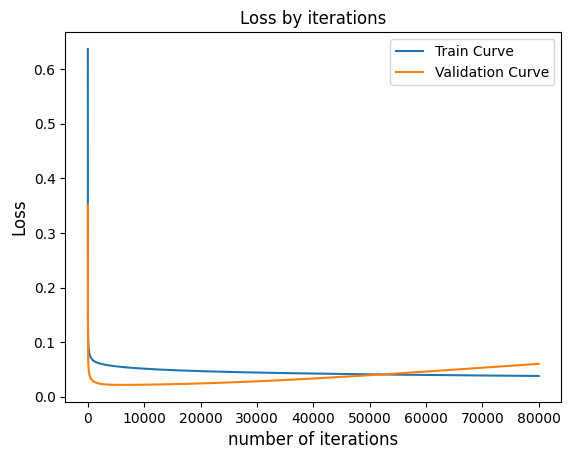

GPU time: 65.87019s


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = model.to(torch.device('cuda:0'))


start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()

iteration_number = 80000
model=LogisticRegression(n_features)
criterion=nn.BCELoss()
learning_rate=0.23
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)

#The validation Curve
def val_curve():
  loss_train = []
  loss_val=[]

  for epoch in range(1, iteration_number+1):

      # Forward to get output
      results = model(X_train)

        # Calculate Loss
      loss = criterion(results, y_train)

        # backward propagation
      loss.backward()

        # Updating parameters
      optimizer.step()

        # optimization
      optimizer.zero_grad()

      # store loss
      loss_train.append(loss.data)

      with torch.no_grad():
        y_val_predictions = model(X_val)
        y_val_predictions_classes = y_val_predictions.round()
        loss_val.append(criterion(y_val_predictions,y_val))
        # loss_val = 0

  return loss_train, loss_val




alpha = np.linspace(1,iteration_number,iteration_number)
loss_train, loss_val = val_curve()

plt.plot(alpha, loss_train,label='Train Curve')
plt.plot(alpha, loss_val,label='Validation Curve')

plt.xlabel('number of iterations', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.title('Loss by iterations')
plt.show()
end.record()
torch.cuda.synchronize()  # Waits for everything to finish running on the GPU
print(f"GPU time: {0.001 * start.elapsed_time(end):6.5f}s")  # Milliseconds to seconds


<ipython-input-7-367e5b6a5834>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fpr, tpr, thresholds = roc_curve(y_test, torch.tensor((model(X_test))))


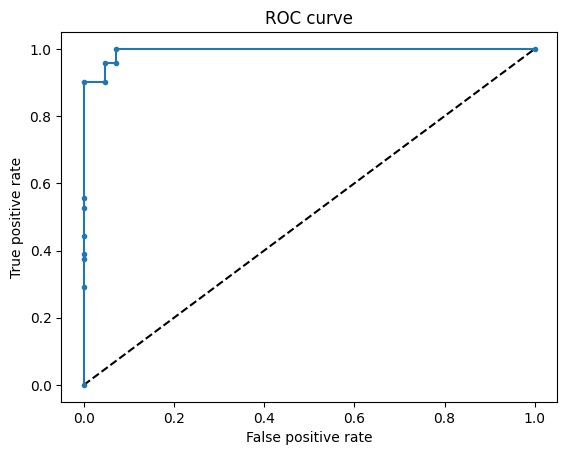

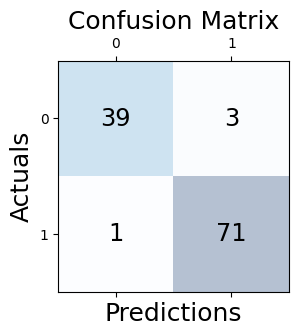

GPU time: 66.29424s


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, torch.tensor((model(X_test))))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

#Finding The Optimal Threshold

gmean = np.sqrt(tpr * (1 - fpr))
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)


def convert_binary(set):
  results=[]
  for i in range(len(set)):
    if set[i]>thresholdOpt:
      results.append(1)
    else:
      results.append(0)
  return results


conf_matrix =confusion_matrix(y_test, convert_binary(model(X_test)))
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

end.record()
torch.cuda.synchronize()  # Waits for everything to finish running on the GPU
print(f"GPU time: {0.001 * start.elapsed_time(end):6.5f}s")  # Milliseconds to seconds




#tuning learning rate of logistic regression

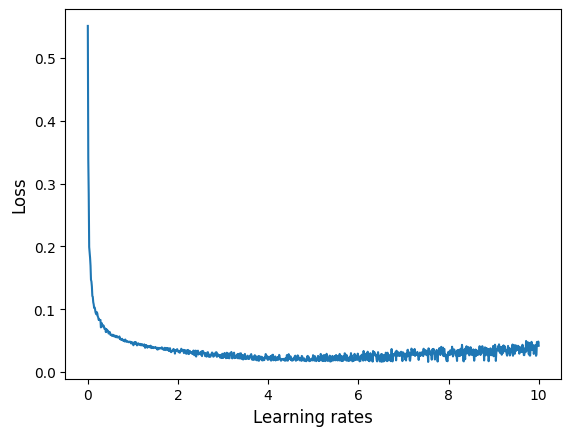

In [ ]:

import random
alpha=np.linspace(0.001,10,1000)
rows_idxs = list(range(X_train.shape[0]))
model=LogisticRegression(n_features)
def rate_tune():
  loss_history=[]
  epochs=40
  for learning_rate in alpha:
    model=LogisticRegression(n_features)
    optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)
    for k in range(epochs):


        y_train_pred_probablity = model(X_train)

        # optimization
        optimizer.zero_grad()

      # Forward to get output
        results = model(X_train)

      # Calculate Loss
        loss = criterion(y_train_pred_probablity, y_train)

      # backward propagation
        loss.backward()

      # Updating parameters
        optimizer.step()


        optimizer.zero_grad()

      # # store loss
      # loss_history.append(loss.data)


    y_val_pred_probablity = model(X_val)
    loss_history.append(criterion(y_val_pred_probablity, y_val).item())
  return loss_history

rate_tune()
plt.plot(alpha, rate_tune())
plt.xlabel('Learning rates', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.show()


#Neural Networks

In [ ]:
class neural_classification(nn.Module):
  def __init__(self,input_size,hidden1_size,hidden2_size,num_classes):

    super(neural_classification,self).__init__()

    self.fc1=nn.Linear(input_size,hidden1_size)

    self.fc2=nn.Linear(hidden1_size,hidden2_size)

    self.fc3=nn.Linear(hidden2_size,num_classes)

  def forward(self,x):


      x= torch.relu(self.fc1(x))

      x= torch.relu(self.fc2(x))

      x=torch.sigmoid(self.fc3(x))

      return x


epoch 0, loss 0.7055963277816772
epoch 50, loss 0.16747501492500305
epoch 100, loss 0.10566475242376328
epoch 150, loss 0.08164388686418533


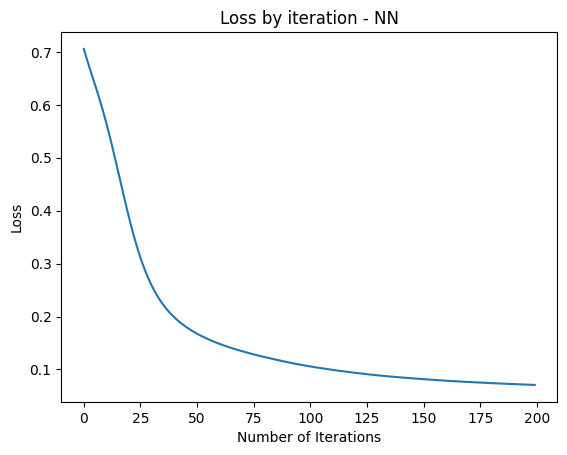

<ipython-input-10-d938ec6778a4>:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fpr, tpr, thresholds = roc_curve(torch.tensor(y_test, device = 'cpu'), torch.tensor(model_NN(X_test.cuda()), device = 'cpu'))


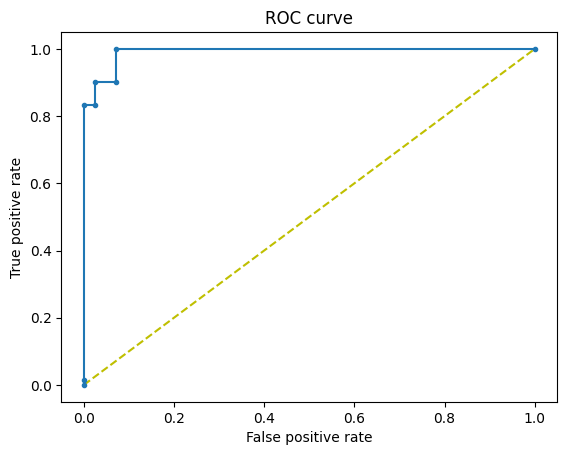

<ipython-input-10-d938ec6778a4>:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conf_matrix =confusion_matrix(torch.tensor(y_test, device = 'cpu'), torch.tensor(convert_binary(model_NN(X_test.cuda())), device = 'cpu'))


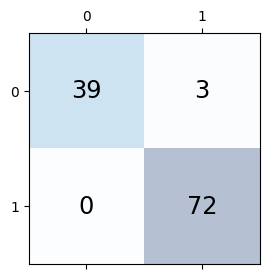

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


model_NN=neural_classification(24,10,50,1)
model_NN = model_NN.to(torch.device('cuda:0'))


start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()




learning_rate=0.1
#I use binary cross entropy loss function because here we have a binary classification mission
criterion=nn.BCELoss()
optimizer=torch.optim.SGD(model_NN.parameters(),lr=learning_rate)


# train model
loss_list = []
iteration_number = 200
for iteration in range(iteration_number):
  y_prediction=model_NN(X_train.cuda())

    # optimization
  optimizer.zero_grad()

    # Forward to get output
  results = model_NN(X_train.cuda())

    # Calculate Loss
  loss = criterion(y_prediction,y_train.cuda())

    # backward propagation
  loss.backward()

    # Updating parameters
  optimizer.step()

    # store loss
  loss_list.append(loss.data)

    # print loss
  if(iteration % 50 == 0):
    print('epoch {}, loss {}'.format(iteration, loss.data))

cpu_loss_list = torch.tensor(loss_list, device = 'cpu')
plt.plot(range(iteration_number),cpu_loss_list)
plt.title("Loss by iteration - NN")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()


fpr, tpr, thresholds = roc_curve(torch.tensor(y_test, device = 'cpu'), torch.tensor(model_NN(X_test.cuda()), device = 'cpu'))


plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()



#finding the optimal threshold

gmean = np.sqrt(tpr * (1 - fpr))
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)

def convert_binary(set):
  results=[]
  for i in range(len(set)):
    if set[i]>thresholdOpt:
      results.append(1)
    else:
      results.append(0)
  return results

conf_matrix =confusion_matrix(torch.tensor(y_test, device = 'cpu'), torch.tensor(convert_binary(model_NN(X_test.cuda())), device = 'cpu'))

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.show()

